In [1]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)

In [2]:
df = pl.read_csv('./dataset/CUSTOMER_SCORE_금리.csv')

In [3]:
def aggregate_customer_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    고객 단위로 주요 금융 항목을 집계하여 요약 데이터를 생성합니다.

    처리 내용:
    1. '기준금리', '성별' 컬럼 제거
    2. 고객ID 기준 그룹화 후 다음과 같이 집계:
        - 입출금예금, 기타예금, 비이자상품, 카드, 대출, 총점수: 평균값
        - 거래기간(개월), 연령대: 최대값
        - 보유상품수:
            - 최대_보유상품종류: 최대값
            - 평균_보유상품종류: 평균값을 반올림 후 Int8 형으로 변환

    Parameters:
        df (pl.DataFrame): 원본 고객 월별 데이터

    Returns:
        pl.DataFrame: 고객ID 기준으로 집계된 요약 데이터프레임
    """
    df_dropped = df.drop(["기준금리", "성별"])

    df_agg = (
        df_dropped
        .group_by("고객ID")
        .agg([
            pl.col("입출금예금").mean().alias("평균_입출금예금"),
            pl.col("기타예금").mean().alias("평균_기타예금"),
            pl.col("비이자상품").mean().alias("평균_비이자상품"),
            pl.col("카드").mean().alias("평균_카드"),
            pl.col("대출").mean().alias("평균_대출"),
            pl.col("총점수").mean().alias("평균_총점수"),
            pl.col("거래기간(개월)").max().alias("거래기간(개월)"),
            pl.col("연령대").max().alias("연령대"),
            pl.col("보유상품수").max().alias("최대_보유상품종류"),
            pl.col("보유상품수").mean().round(0).cast(pl.Int8).alias("평균_보유상품종류")
        ])
    )
    return df_agg

In [4]:
temp = df.clone()
customer_agg = aggregate_customer_data(temp)

In [5]:
customer_agg.head()

고객ID,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_총점수,거래기간(개월),연령대,최대_보유상품종류,평균_보유상품종류
i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i8
9012117489,87096.774194,538709.677419,0.0,16774.193548,0.0,62.266667,36,40,3,2
8605146189,2.2877e7,2.6433e6,0.0,0.0,0.0,1999.444444,36,60,2,2
9409471317,3.2774e6,251612.903226,0.0,3225.806452,0.0,310.473118,36,60,3,1
6737597329,441935.483871,0.0,0.0,0.0,0.0,57.505376,36,40,1,1
3266180911,3225.806452,0.0,0.0,8064.516129,0.0,14.935484,36,20,1,0


In [6]:
#customer_agg.write_csv('./dataset/customer_agg.csv')

In [7]:
clustering_origin = customer_agg[['고객ID', '연령대', '평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출', '평균_보유상품종류']].clone()

In [8]:
clustering_origin

고객ID,연령대,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_보유상품종류
i64,i64,f64,f64,f64,f64,f64,i8
9012117489,40,87096.774194,538709.677419,0.0,16774.193548,0.0,2
8605146189,60,2.2877e7,2.6433e6,0.0,0.0,0.0,2
9409471317,60,3.2774e6,251612.903226,0.0,3225.806452,0.0,1
6737597329,40,441935.483871,0.0,0.0,0.0,0.0,1
3266180911,20,3225.806452,0.0,0.0,8064.516129,0.0,0
…,…,…,…,…,…,…,…
6578732621,30,41935.483871,0.0,0.0,0.0,0.0,0
2060407647,60,0.0,3.1e7,0.0,0.0,0.0,1
4729262312,20,541935.483871,1.0258e6,0.0,325483.870968,0.0,3


# 비지도학습 기반 분류 (평균_입출금예금, 평균_기타예금,	평균_비이자상품, 평균_카드,	평균_대출,	평균_보유상품종류, best k 찾기)

In [9]:
# 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import pandas as pd

In [10]:
# 데이터 준비
df = clustering_origin.clone()
# Polars에서 수치형 컬럼만 추출
numeric_columns = [col for col, dtype in df.schema.items() if dtype in pl.NUMERIC_DTYPES]
exclude_cols = ["고객ID", "연령대"]  # 분석에서 제외할 컬럼
use_columns = [col for col in numeric_columns if col not in exclude_cols]

X = df.select(use_columns)
X_scaled = StandardScaler().fit_transform(X.to_numpy())

In [11]:
X

평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_보유상품종류
f64,f64,f64,f64,f64,i8
87096.774194,538709.677419,0.0,16774.193548,0.0,2
2.2877e7,2.6433e6,0.0,0.0,0.0,2
3.2774e6,251612.903226,0.0,3225.806452,0.0,1
441935.483871,0.0,0.0,0.0,0.0,1
3225.806452,0.0,0.0,8064.516129,0.0,0
…,…,…,…,…,…
41935.483871,0.0,0.0,0.0,0.0,0
0.0,3.1e7,0.0,0.0,0.0,1
541935.483871,1.0258e6,0.0,325483.870968,0.0,3


In [12]:
X_scaled

array([[-0.4278453 , -0.23339319, -0.07281139, -0.33235904, -0.25638575,
         0.60892361],
       [ 2.83989345, -0.00309186, -0.07281139, -0.37714088, -0.25638575,
         0.60892361],
       [ 0.02960698, -0.26480914, -0.07281139, -0.36852899, -0.25638575,
        -0.40445941],
       ...,
       [-0.36262713, -0.18009196, -0.07281139,  0.49179912, -0.25638575,
         1.62230664],
       [-0.38011115, -0.29234223, -0.07281139, -0.37714088,  2.30157475,
        -0.40445941],
       [-0.301726  , -0.29234223, -0.07281139, -0.37714088, -0.25638575,
        -0.40445941]])

## k means

In [13]:
results = []

# k값을 2부터 9까지 반복하며 클러스터 평가
for k in range(2, 10):
    # KMeans 클러스터링 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
    X_sampled, labels_sampled = resample(
        X_scaled, labels,
        n_samples=min(10000, len(X_scaled)),
        random_state=42
    )

    # 세 가지 평가 지표 계산
    results.append({
        "k": k,
        "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),     # 분산 기반 평가
        "davies_bouldin": davies_bouldin_score(X_scaled, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
    })

# 리스트 → DataFrame 변환
result_kmeans = pd.DataFrame(results)

# 각 지표에 대해 순위 계산
# silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# db는 작을수록 좋으므로 오름차순(ascending=True)
result_kmeans["rank_silhouette"] = result_kmeans["silhouette"].rank(ascending=False)
result_kmeans["rank_ch"] = result_kmeans["calinski_harabasz"].rank(ascending=False)
result_kmeans["rank_db"] = result_kmeans["davies_bouldin"].rank(ascending=True)

# 평균 순위 계산 → 종합 평가 지표로 활용
result_kmeans["rank_avg"] = result_kmeans[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

# 평균 순위가 가장 낮은(즉, 전체적으로 가장 높은 평가를 받은) k를 Best k로 선정
best_k_rank = result_kmeans.loc[result_kmeans["rank_avg"].idxmin(), "k"]

In [14]:
result_kmeans

,k,silhouette,calinski_harabasz,davies_bouldin,rank_silhouette,rank_ch,rank_db,rank_avg
0,2,0.561989,514714.847142,1.526511,1.0,5.0,8.0,4.666667
1,3,0.522007,445086.001509,1.457856,2.0,7.0,7.0,5.333333
2,4,0.520286,414470.447305,1.397805,3.0,8.0,6.0,5.666667
3,5,0.479545,479298.711635,1.229954,5.0,6.0,5.0,5.333333
4,6,0.486391,595905.085192,0.918680,4.0,3.0,4.0,3.666667
5,7,0.465382,649635.749108,0.876104,6.0,1.0,2.0,3.000000
6,8,0.442583,611645.510631,0.842680,8.0,2.0,1.0,3.666667
7,9,0.454175,585936.987096,0.897442,7.0,4.0,3.0,4.666667


In [15]:
best_k_rank

7

In [16]:
# # kmeans seaborn 시각화
# # KMeans 클러스터링 평가 결과 데이터프레임 복사 (원본 데이터 유지)
# result_df = result_kmeans.copy()

# # 클러스터 평가 지표 정의
# metrics = {
#     "silhouette": "max",          # Silhouette Score: 클수록 좋음 (0~1)
#     "calinski_harabasz": "max",   # Calinski-Harabasz Score: 클수록 좋음
#     "davies_bouldin": "min",      # Davies-Bouldin Score: 작을수록 좋음
# }

# # 정의된 평가 지표에 대해 반복 실행
# for metric, direction in metrics.items():
#     plt.figure(figsize=(8, 4))  # 그래프 크기 설정

#     # K별 metric 점수 그래프 그리기
#     sns.lineplot(data=result_df, x="k", y=metric, marker="o", color="mediumaquamarine")

#     # 최적 k값 찾기 (각 지표의 최고 또는 최저값)
#     if direction == "max":
#         best_idx = result_df[metric].idxmax()  # 가장 큰 값의 인덱스 찾기
#     else:
#         best_idx = result_df[metric].idxmin()  # 가장 작은 값의 인덱스 찾기

#     best_k = result_df.loc[best_idx, "k"]  # 최적 k값
#     best_score = result_df.loc[best_idx, metric]  # 최적 metric 점수

#     # 최적 k값에 주석(Annotate) 추가
#     plt.annotate(
#         f"최적 k = {best_k}\n{metric} = {best_score:.3f}",  # 텍스트 내용
#         xy=(best_k, best_score),  # 화살표 위치 (x, y)
#         xytext=(best_k + 0.5, best_score + 0.05 * best_score),  # 텍스트 위치 (조금 위쪽)
#         arrowprops=dict(arrowstyle="->", color="gray"),  # 화살표 스타일
#         fontsize=10,  # 폰트 크기
#         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)  # 텍스트 배경 스타일
#     )

#     # 그래프 제목 및 라벨 설정
#     plt.title(f"KMeans 군집 수 별 {metric} 점수 추이", fontsize=14)
#     plt.xlabel("k (클러스터 수)")
#     plt.ylabel(metric)
#     plt.grid(True, linestyle='--', alpha=0.5)  # 점선 형태의 그리드 추가
#     plt.tight_layout()  # 레이아웃 최적화
#     plt.show()  # 그래프 출력

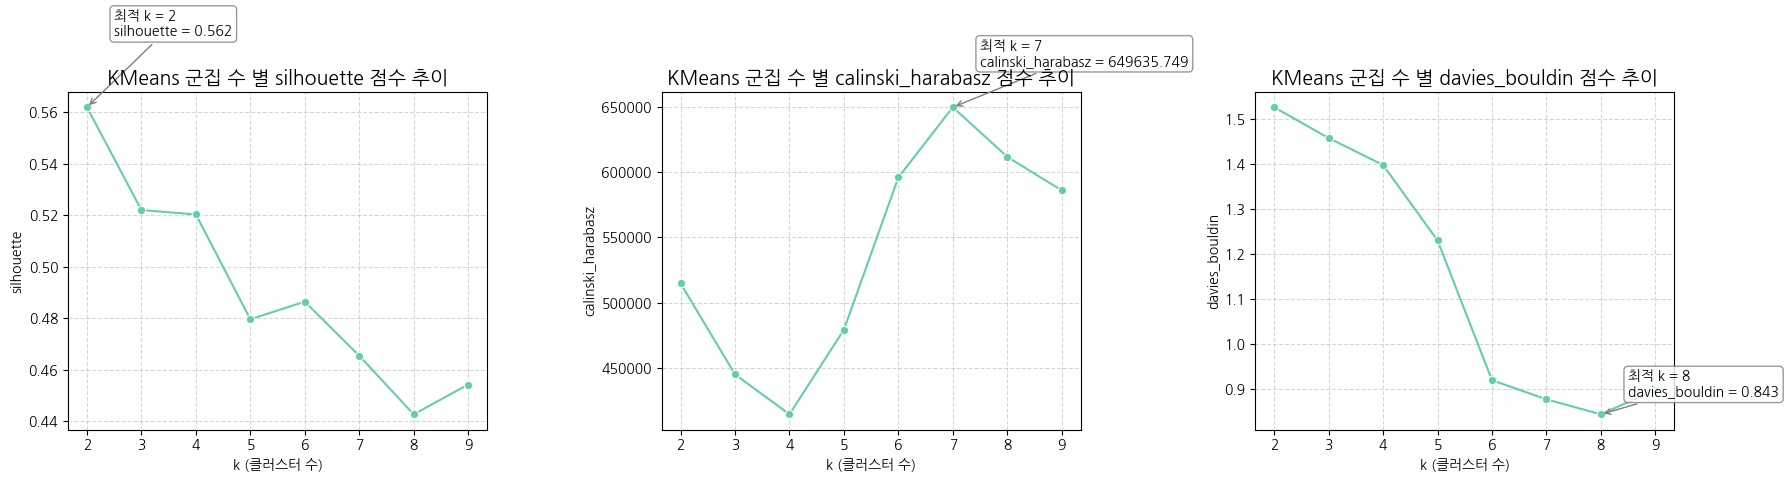

In [17]:
# KMeans 클러스터링 평가 결과 데이터프레임 복사 (원본 데이터 유지)
result_df = result_kmeans.copy()

# 클러스터 평가 지표 정의
metrics = {
    "silhouette": "max",          # Silhouette Score: 클수록 좋음 (0~1)
    "calinski_harabasz": "max",   # Calinski-Harabasz Score: 클수록 좋음
    "davies_bouldin": "min",      # Davies-Bouldin Score: 작을수록 좋음
}

# 서브플롯 생성 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 각 지표에 대한 그래프 그리기
for i, (metric, direction) in enumerate(metrics.items()):
    # K별 metric 점수 그래프 그리기
    sns.lineplot(data=result_df, x="k", y=metric, marker="o", color="mediumaquamarine", ax=axes[i])

    # 최적 k값 찾기 (각 지표의 최고 또는 최저값)
    if direction == "max":
        best_idx = result_df[metric].idxmax()  # 가장 큰 값의 인덱스 찾기
    else:
        best_idx = result_df[metric].idxmin()  # 가장 작은 값의 인덱스 찾기

    best_k = result_df.loc[best_idx, "k"]  # 최적 k값
    best_score = result_df.loc[best_idx, metric]  # 최적 metric 점수

    # 최적 k값에 주석(Annotate) 추가
    axes[i].annotate(
        f"최적 k = {best_k}\n{metric} = {best_score:.3f}",
        xy=(best_k, best_score),
        xytext=(best_k + 0.5, best_score + 0.05 * best_score),
        arrowprops=dict(arrowstyle="->", color="gray"),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

    # 그래프 제목 및 라벨 설정
    axes[i].set_title(f"KMeans 군집 수 별 {metric} 점수 추이", fontsize=14)
    axes[i].set_xlabel("k (클러스터 수)")
    axes[i].set_ylabel(metric)
    axes[i].grid(True, linestyle='--', alpha=0.5)

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

## 최적 K 정하기

In [18]:
# elbow point 자동 탐지 코드로 최적 k 찾아보기

In [19]:
!pip install kneed

### k means

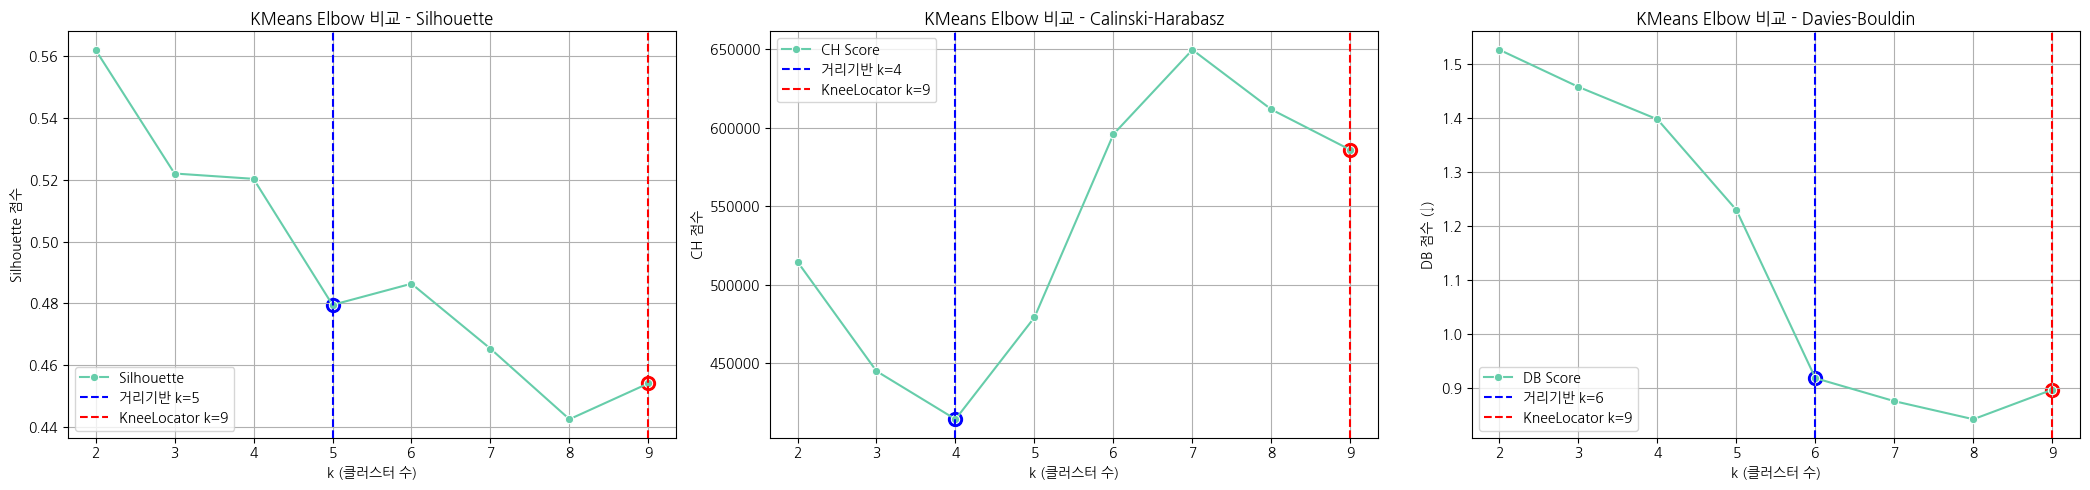

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kneed import KneeLocator

# ✅ 거리기반 elbow 계산 함수
def find_elbow_point(df, score_col):
    x = df["k"].to_numpy()
    y = df[score_col].to_numpy()
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    distances = []
    for i in range(len(x)):
        point = np.array([x[i], y[i]])
        vec_line = end - start
        vec_point = point - start
        proj_len = np.dot(vec_line, vec_point) / np.linalg.norm(vec_line)
        proj_point = start + proj_len * vec_line / np.linalg.norm(vec_line)
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)
    best_idx = int(np.argmax(distances))
    return int(x[best_idx])

# ✅ KneeLocator 방식
def find_elbow_kneedf(df, metric, direction="increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee

# ✅ 개별 지표 처리 ------------------------------

# Silhouette
df_sil = result_kmeans[["k", "silhouette"]].copy()
elbow_kmeans_dist_sil = find_elbow_point(df_sil, "silhouette")
elbow_kmeans_knee_sil = find_elbow_kneedf(df_sil, "silhouette", direction="increasing")
score_dist_sil = df_sil[df_sil["k"] == elbow_kmeans_dist_sil]["silhouette"].values[0]
score_knee_sil = df_sil[df_sil["k"] == elbow_kmeans_knee_sil]["silhouette"].values[0]

# CH
df_ch = result_kmeans[["k", "calinski_harabasz"]].copy()
elbow_kmeans_distance_ch = find_elbow_point(df_ch, "calinski_harabasz")
elbow_kmeans_knee_ch = find_elbow_kneedf(df_ch, "calinski_harabasz", direction="increasing")
score_dist_ch = df_ch[df_ch["k"] == elbow_kmeans_distance_ch]["calinski_harabasz"].values[0]
score_knee_ch = df_ch[df_ch["k"] == elbow_kmeans_knee_ch]["calinski_harabasz"].values[0]

# DB
df_db = result_kmeans[["k", "davies_bouldin"]].copy()
elbow_kmeans_distance_db = find_elbow_point(df_db, "davies_bouldin")
elbow_kmeans_knee_db = find_elbow_kneedf(df_db, "davies_bouldin", direction="decreasing")
score_dist_db = df_db[df_db["k"] == elbow_kmeans_distance_db]["davies_bouldin"].values[0]
score_knee_db = df_db[df_db["k"] == elbow_kmeans_knee_db]["davies_bouldin"].values[0]

# ✅ 시각화 ------------------------------

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- Silhouette
sns.lineplot(data=df_sil, x="k", y="silhouette", ax=axes[0], color="mediumaquamarine", marker="o", label="Silhouette")
axes[0].axvline(x=elbow_kmeans_dist_sil, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_dist_sil}")
axes[0].scatter(elbow_kmeans_dist_sil, score_dist_sil, color="blue", s=100)
axes[0].axvline(x=elbow_kmeans_knee_sil, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_sil}")
axes[0].scatter(elbow_kmeans_knee_sil, score_knee_sil, color="red", s=100)
axes[0].set_title("KMeans Elbow 비교 - Silhouette")
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].legend()
axes[0].grid(True)

# --- CH
sns.lineplot(data=df_ch, x="k", y="calinski_harabasz", ax=axes[1], color="mediumaquamarine", marker="o", label="CH Score")
axes[1].axvline(x=elbow_kmeans_distance_ch, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_distance_ch}")
axes[1].scatter(elbow_kmeans_distance_ch, score_dist_ch, color="blue", s=100)
axes[1].axvline(x=elbow_kmeans_knee_ch, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_ch}")
axes[1].scatter(elbow_kmeans_knee_ch, score_knee_ch, color="red", s=100)
axes[1].set_title("KMeans Elbow 비교 - Calinski-Harabasz")
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].legend()
axes[1].grid(True)

# --- DB
sns.lineplot(data=df_db, x="k", y="davies_bouldin", ax=axes[2], color="mediumaquamarine", marker="o", label="DB Score")
axes[2].axvline(x=elbow_kmeans_distance_db, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_distance_db}")
axes[2].scatter(elbow_kmeans_distance_db, score_dist_db, color="blue", s=100)
axes[2].axvline(x=elbow_kmeans_knee_db, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_db}")
axes[2].scatter(elbow_kmeans_knee_db, score_knee_db, color="red", s=100)
axes[2].set_title("KMeans Elbow 비교 - Davies-Bouldin")
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


# 라벨 붙이기

In [21]:
customer_agg

고객ID,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_총점수,거래기간(개월),연령대,최대_보유상품종류,평균_보유상품종류
i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i8
9012117489,87096.774194,538709.677419,0.0,16774.193548,0.0,62.266667,36,40,3,2
8605146189,2.2877e7,2.6433e6,0.0,0.0,0.0,1999.444444,36,60,2,2
9409471317,3.2774e6,251612.903226,0.0,3225.806452,0.0,310.473118,36,60,3,1
6737597329,441935.483871,0.0,0.0,0.0,0.0,57.505376,36,40,1,1
3266180911,3225.806452,0.0,0.0,8064.516129,0.0,14.935484,36,20,1,0
…,…,…,…,…,…,…,…,…,…,…
6578732621,41935.483871,0.0,0.0,0.0,0.0,20.387097,36,30,1,0
2060407647,0.0,3.1e7,0.0,0.0,0.0,536.666667,2,60,1,1
4729262312,541935.483871,1.0258e6,0.0,325483.870968,0.0,172.513978,36,20,3,3


In [22]:
clustering_origin

고객ID,연령대,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_보유상품종류
i64,i64,f64,f64,f64,f64,f64,i8
9012117489,40,87096.774194,538709.677419,0.0,16774.193548,0.0,2
8605146189,60,2.2877e7,2.6433e6,0.0,0.0,0.0,2
9409471317,60,3.2774e6,251612.903226,0.0,3225.806452,0.0,1
6737597329,40,441935.483871,0.0,0.0,0.0,0.0,1
3266180911,20,3225.806452,0.0,0.0,8064.516129,0.0,0
…,…,…,…,…,…,…,…
6578732621,30,41935.483871,0.0,0.0,0.0,0.0,0
2060407647,60,0.0,3.1e7,0.0,0.0,0.0,1
4729262312,20,541935.483871,1.0258e6,0.0,325483.870968,0.0,3


In [23]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time
import polars as pl

def add_clustering_label(df: pl.DataFrame, label_name: str, k: int, X):
    """KMeans 또는 GMM 클러스터링 라벨을 df에 추가하고 소요시간 출력"""
    print(f"▶ 실행 중: {label_name} (k={k})")
    start = time.time()

    # 모델 선택 및 학습
    if label_name.startswith("KMeans"):
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
    elif label_name.startswith("GMM"):
        model = GaussianMixture(n_components=k, random_state=42)
        labels = model.fit_predict(X)
    else:
        raise ValueError(f"Unknown model type in label: {label_name}")

    # ✅ Polars에서는 with_columns로 라벨 추가해야 함
    df = df.with_columns(pl.Series(label_name, labels))

    end = time.time()
    print(f"✅ 완료: {label_name} | 소요시간: {end - start:.2f}초\n")
    return df

In [24]:
k_values = {
    #"KMeans_실루엣_거리기반": elbow_kmeans_distance_sil,
    #"KMeans_실루엣_KneeLocator": elbow_kmeans_knee_sil,
    #"KMeans_CH_거리기반": elbow_kmeans_distance_ch,
    #"KMeans_CH_KneeLocator": elbow_kmeans_knee_ch,
    "KMeans_DB_거리기반": elbow_kmeans_distance_db,
    #"KMeans_DB_KneeLocator": elbow_kmeans_knee_db,
    # "GMM_실루엣_거리기반": elbow_k_distance_gmm_sil,
    # "GMM_실루엣_KneeLocator": elbow_k_knee_gmm_sil,
    # "GMM_CH_거리기반": elbow_k_distance_gmm_ch,
    # "GMM_CH_KneeLocator": elbow_k_knee_gmm_ch,
    # "GMM_DB_거리기반": elbow_k_distance_gmm_db,
    # "GMM_DB_KneeLocator": elbow_k_knee_gmm_db,
}


In [25]:
for label, k in k_values.items():
    df = clustering_origin.clone()
    df = add_clustering_label(df, label, k, X)
    # df.write_parquet("중간저장.parquet") 등도 가능

▶ 실행 중: KMeans_DB_거리기반 (k=6)
✅ 완료: KMeans_DB_거리기반 | 소요시간: 1.14초



In [26]:
df.head()

고객ID,연령대,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출,평균_보유상품종류,KMeans_DB_거리기반
i64,i64,f64,f64,f64,f64,f64,i8,i32
9012117489,40,87096.774194,538709.677419,0.0,16774.193548,0.0,2,0
8605146189,60,2.2877e7,2.6433e6,0.0,0.0,0.0,2,4
9409471317,60,3.2774e6,251612.903226,0.0,3225.806452,0.0,1,0
6737597329,40,441935.483871,0.0,0.0,0.0,0.0,1,0
3266180911,20,3225.806452,0.0,0.0,8064.516129,0.0,0,0


In [27]:
df.shape

(1978693, 9)

In [28]:
customer_agg.shape

(1978693, 11)

In [30]:
df['KMeans_DB_거리기반'].value_counts()

KMeans_DB_거리기반,count
i32,u32
5,83356
1,31695
3,26122
2,61961
4,154061
0,1621498


In [29]:
#df.write_csv('./dataset/클러스터링결과_전체_kmeans_db_6.csv')

In [ ]:
dict_cluster = {
    0: 'A',
    1: 'B',
    2: 'D',
    3: 'D',
    4: 'C',
    5: 'B',
    6: 'C',
    7: 'C',
    8: 'D'
}